In [1]:
from sympy import *
from IPython.display import display
from sympy.plotting import plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

%matplotlib widget

#thrust from cost estimate
fuel_usage, thrust, thrust_multiplier, cost_scale = symbols("f, T, T_m, c_s", real=True, nonnegative=True)
t_a, t_b, t_c = symbols("t_a, t_b, t_c", real=True)
#.1 -> .1
#.8 -> 1
#dT/dx = 
thrust_factor = t_a * fuel_usage ** 2 + t_b * fuel_usage + t_c
tfs1 = Eq(thrust_factor.subs(fuel_usage, Rational(1, 10)), Rational(1, 10))
tfs2 = Eq(thrust_factor.subs(fuel_usage, 1), 1)
tfs3 = Eq(thrust_factor.diff(fuel_usage).subs(fuel_usage, 1), 0)
tfssolved = solve([tfs1, tfs2, tfs3], (t_a, t_b, t_c))
thrust_expression = (thrust_factor * thrust_multiplier).subs(tfssolved)
display(thrust_expression)

width, grab_range, mass, velocity = symbols("w, r, m, v", real=True, nonnegative=True)
gravity = symbols("g", real=True)

acceleration_expression = thrust / (1 + mass * Rational(1, 10000)) - (width * ((gravity + velocity)**2 + 60*(gravity + velocity)))/4800 - 10
display(acceleration_expression)
velocity_expression = solve(acceleration_expression, velocity)[1]
display(velocity_expression)

def sympy_fixed_min(a, b):
    return Piecewise((b, a > b), (a, True))

thuster_multi_expression = 100 * sympy_fixed_min(floor((width - 1) / 4), 100)

replacements = {velocity: velocity_expression.subs(thrust, thrust_expression).subs(thrust_multiplier, thuster_multi_expression).subs(gravity, 10), 
                thrust: thrust_expression, gravity: 10, thrust_multiplier: thuster_multi_expression}
exemplar_replacements = {thrust_multiplier: 100, width: 10, mass: 200, grab_range: 15}
pickup_efficiency_expression = (velocity * (width + grab_range) - cost_scale * fuel_usage * sympy_fixed_min(floor((width - 1) / 4), 10)).subs(replacements).subs(grab_range, 15)
display(pickup_efficiency_expression)

display(velocity_expression.subs(replacements))
vel_exp = 10 * sqrt((480000 * thrust / (mass + 10000) - 480) / width + 9) - 30 - gravity
display(vel_exp.subs(replacements))
display(thuster_multi_expression.subs(width, 100))
display(vel_exp.subs(replacements).subs(width, 100).subs(fuel_usage, .1).subs(mass, 338))

pickup_efficiency_function = lambdify((mass, width, fuel_usage, cost_scale), pickup_efficiency_expression, modules='numpy')
velocity_function = lambdify((mass, width, fuel_usage, cost_scale), vel_exp.subs(replacements), modules='numpy')


T_m*(-10*f**2/9 + 20*f/9 - 1/9)

T/(m/10000 + 1) - w*(60*g + 60*v + (g + v)**2)/4800 - 10

-g - 30 + 10*sqrt(480000*T + 9*m*w - 480*m + 90000*w - 4800000)/(sqrt(w)*sqrt(m + 10000))

-c_s*f*Piecewise((10, w >= 45), (floor(w/4 - 1/4), True)) + (-40 + 10*sqrt(9*m*w - 480*m + 90000*w + 48000000*(-10*f**2/9 + 20*f/9 - 1/9)*Piecewise((100, w >= 405), (floor(w/4 - 1/4), True)) - 4800000)/(sqrt(w)*sqrt(m + 10000)))*(w + 15)

-40 + 10*sqrt(9*m*w - 480*m + 90000*w + 48000000*(-10*f**2/9 + 20*f/9 - 1/9)*Piecewise((100, w >= 405), (floor(w/4 - 1/4), True)) - 4800000)/(sqrt(w)*sqrt(m + 10000))

10*sqrt(9 + (-480 + 48000000*(-10*f**2/9 + 20*f/9 - 1/9)*Piecewise((100, w >= 405), (floor(w/4 - 1/4), True))/(m + 10000))/w) - 40

2400

67.5330396391978

In [2]:
#print(float(pickup_efficiency_expression.subs([(mass, 1000), (width, 8), (gravity, 10), (thrust_multiplier, 100), (fuel_usage, .2)])))
print(pickup_efficiency_function(338, 100, .1, 2000))
print(velocity_function(338, 100, .1, 1000))

5766.29955850774
67.53303963919775


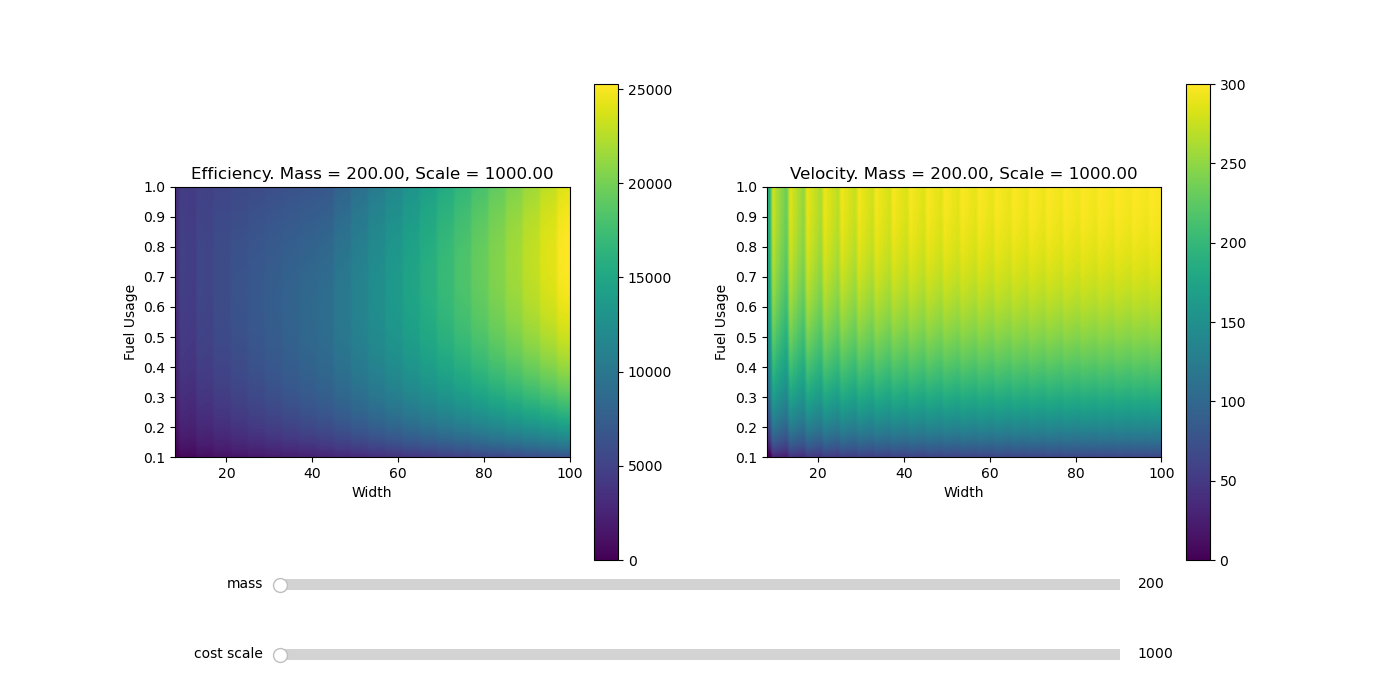

In [3]:
width_vals = np.linspace(8, 100, 92)
fuel_vals = np.linspace(.1, 1, 100)
W, F = np.meshgrid(width_vals, fuel_vals)

mass_init = 200
cost_scale_init = 1000

heatmap_data1 = pickup_efficiency_function(mass_init, W, F, cost_scale_init)
heatmap_data2 = velocity_function(mass_init, W, F, cost_scale_init)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plt.subplots_adjust(bottom=0.2, wspace=.2)

heatmap1 = ax1.imshow(
    heatmap_data1, 
    extent=[width_vals.min(), width_vals.max(), fuel_vals.min(), fuel_vals.max()],
    origin='lower', 
    cmap='viridis',
    aspect=70
)
ax1.set_title(f"Efficiency. Mass = {mass_init:.2f}, Scale = {cost_scale_init:.2f}")
ax1.set_xlabel('Width')
ax1.set_ylabel('Fuel Usage')
plt.colorbar(heatmap1, ax=ax1)

heatmap2 = ax2.imshow(
    heatmap_data2, 
    extent=[width_vals.min(), width_vals.max(), fuel_vals.min(), fuel_vals.max()],
    origin='lower', 
    cmap='viridis',
    aspect=70
)
ax2.set_title(f"Velocity. Mass = {mass_init:.2f}, Scale = {cost_scale_init:.2f}")
ax2.set_xlabel('Width')
ax2.set_ylabel('Fuel Usage')
plt.colorbar(heatmap2, ax=ax2)

ax_slider_mass = plt.axes([0.2, 0.15, 0.6, 0.03])  # Position of the slider
ax_slider_cost = plt.axes([0.2, 0.05, 0.6, 0.03])  # Position of the slider
slider_mass = Slider(ax_slider_mass, 'mass', mass_init, 1000, valinit=mass_init)
slider_cost = Slider(ax_slider_cost, 'cost scale', cost_scale_init, 10000, valinit=cost_scale_init)
heatmap1.set_clim(vmin=0, vmax=heatmap_data1.max())
heatmap2.set_clim(vmin=0, vmax=heatmap_data2.max())
def update(val):
    mass_val = slider_mass.val
    cost_val = slider_cost.val
    heatmap_data1 = pickup_efficiency_function(mass_val, W, F, cost_val)
    heatmap_data2 = velocity_function(mass_val, W, F, cost_val)
    heatmap1.set_data(heatmap_data1)
    heatmap2.set_data(heatmap_data2)
    heatmap1.set_clim(vmin=0, vmax=heatmap_data1.max())
    heatmap2.set_clim(vmin=0, vmax=heatmap_data2.max())
    ax1.set_title(f"Efficiency. Mass = {mass_val:.2f}, Scale = {cost_val:.2f}")
    ax2.set_title(f"Velocity. Mass = {mass_val:.2f}, Scale = {cost_val:.2f}")
    fig.canvas.draw_idle()

slider_mass.on_changed(update)
slider_cost.on_changed(update)

plt.show()

[(1, 3, 2), (2, 5, 3), (5, 6, 2)]


In [ ]:
from sympy import *
from IPython.display import display
from sympy.plotting import plot
from sympy.polys.ring_series import rs_series, rs_series_reversion

replacements = []

def inverse_taylor_series(f, x, a, n, y):
    #see https://en.wikipedia.org/wiki/Lagrange_inversion_theorem
    #print("===========================")

    b = f.subs(x, a)
    display(b)

    inverse_taylor = a

    for k in range(1, n+1):
        display((y - b)**(k) / factorial(k))
        display((x - a)/(f - b)**k)
        display(((x - a)/(f - b)**k).diff(x, k-1))
        display(limit((((x - a)/(f - b))**k).diff(x, k-1), x, a))
        inverse_taylor += (y - b)**(k) / factorial(k) * limit((((x - a)/(f - b))**k).diff(x, k-1), x, a)
        display(inverse_taylor)

    return inverse_taylor


mass, target_position, target_time, asymptotic_velocity, width, distance = symbols("m, d_f, t_f, v_m, w, d", real=True, nonnegative=True)
gravity = symbols("g", real=True)
quadratic_drag, linear_drag, maximum_drag = symbols("D_q, D_l, D_m", real=True, nonpositive=True)
thrust, fuel_usage = symbols("T, f", real=True, nonnegative=True)
time = symbols("t", real=True, nonnegative=True)
distance_function = Function("d")(time)
s = symbols("s")
distance_laplace = Function("D")(s)

fuel_setting = symbols("f", real=True, nonnegative=True)

thrust_efficiency = Piecewise(
    (1, (fuel_setting <= 0.1)),
    (1 - Rational(5, 7) * (fuel_setting - Rational(1, 10)), (fuel_setting > 0.1) & (fuel_setting <= 0.8)),
    (Rational(1, 2), (fuel_setting > 0.8))
)
thrust_fluid_usage = Piecewise(
    (fuel_setting, (fuel_setting <= 0.1)),
    (Rational(1, 10) + Rational(19, 7) * (fuel_setting - Rational(1, 10)), (fuel_setting > 0.1) & (fuel_setting <= 0.8)),
    (2, (fuel_setting > 0.8))
)
thrust_multiplier = thrust_efficiency * thrust_fluid_usage
thrusters = 5
fuel_usage_multi = 60 * thrusters
base_thrust = 100000000 * thrusters

replacements.insert(0, (fuel_setting, Rational(1, 11)))
replacements.insert(0, (gravity, -10))
replacements.insert(0, (mass, 1000 * 1000))
replacements.insert(0, (width, 25))
replacements.insert(0, (thrust, thrust_multiplier * base_thrust))
replacements.insert(0, (distance_function.subs(time, 0), 0))
replacements.insert(0, (distance_function.diff(time).subs(time, 0), 0))
replacements.insert(0, (quadratic_drag, - width / 4800))
replacements.insert(0, (linear_drag, - 60 * width / 4800))


full_force_equation = Eq(mass * distance_function.diff(time).diff(time), thrust + quadratic_drag * distance_function.diff(time) ** 2 + linear_drag * distance_function.diff(time) + mass * gravity)
display(full_force_equation)

asymptotic_velocity_equation = full_force_equation.subs(distance_function.diff(time).diff(time), 0).subs(distance_function.diff(time), asymptotic_velocity)
#display(asymptotic_velocity_equation)
asymptotic_velocity_expr = solve(asymptotic_velocity_equation, asymptotic_velocity)[0]
display(Eq(asymptotic_velocity, asymptotic_velocity_expr))

replacements.insert(0, (asymptotic_velocity, asymptotic_velocity_expr))

maximum_drag_expr = quadratic_drag * asymptotic_velocity + linear_drag
display(Eq(maximum_drag, maximum_drag_expr))
replacements.insert(0, (maximum_drag, maximum_drag_expr))
simplified_force_equation = Eq(mass * distance_function.diff(time).diff(time), thrust + maximum_drag * distance_function.diff(time) + mass * gravity)
display(simplified_force_equation)

laplace_eq = laplace_transform(simplified_force_equation.lhs - simplified_force_equation.rhs, time, s)[0]
distance_function_expr = inverse_laplace_transform(solve(laplace_eq, laplace_transform(distance_function, time, s))[0], s, time).subs(replacements).subs(Heaviside(time), 1)
display(simplify(distance_function_expr))

display(distance_function_expr.expand())

#distance_function_taylor = series(distance_function_expr, time, 40, 15).removeO()

#display(distance_function_taylor)

#end_time = nsolve(Eq(300000, distance_function_taylor), time, 20)
#display(end_time)

#total_fuel_usage = integrate(fuel_usage_multi * thrust_fluid_usage.subs(replacements), (time, 0, end_time))
#display(total_fuel_usage)

#Rx = distance_function_taylor.as_poly(time).domain[time]
#print(distance_function_taylor.as_poly(time))
#print(Rx)
#distance_function_taylor_rev = Rx.from_sympy(distance_function_taylor)
#print(distance_function_taylor_rev)
#time_rev = Rx.from_sympy(time)
#print(time_rev)

#time_taylor = rs_series_reversion(RS, RS.ring.gens[0], 5)

time_taylor = inverse_taylor_series(distance_function_expr, time, 100, 6, distance)
display(time_taylor)

Eq(m*Derivative(d(t), (t, 2)), D_l*Derivative(d(t), t) + D_q*Derivative(d(t), t)**2 + T + g*m)

Eq(v_m, (-D_l - sqrt(D_l**2 - 4*D_q*T - 4*D_q*g*m))/(2*D_q))

Eq(D_m, D_l + D_q*v_m)

Eq(m*Derivative(d(t), (t, 2)), D_m*Derivative(d(t), t) + T + g*m)

2496000000*((t*(11 + sqrt(915200121)) - 70400000)*exp(t*(11 + sqrt(915200121))/70400000) + 70400000)*exp(-t*(11 + sqrt(915200121))/70400000)/(11 + sqrt(915200121))**2

60937500*t/(25*sqrt(915200121)/512 + 1040000275/512) + 60937500*sqrt(915200121)*t/(275*sqrt(915200121)/512 + 11440003025/512) - 390000000000000/(25*sqrt(915200121)/512 + 1040000275/512) + 390000000000000/(25*sqrt(915200121)*exp(t/6400000)*exp(sqrt(915200121)*t/70400000)/512 + 1040000275*exp(t/6400000)*exp(sqrt(915200121)*t/70400000)/512)

(-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2

d - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2

(t - 100)/((-390000000*t*(-5*sqrt(915200121)/352 - 5/32)/11 + 390000000000000*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 - 390000000000000/11)/(-5*sqrt(915200121)/352 - 5/32)**2 - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)

(t - 100)/((-390000000*t*(-5*sqrt(915200121)/352 - 5/32)/11 + 390000000000000*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 - 390000000000000/11)/(-5*sqrt(915200121)/352 - 5/32)**2 - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)

(40268810648*sqrt(915200121)*exp(1/64000 + sqrt(915200121)/704000) + 837591925913717128*exp(1/64000 + sqrt(915200121)/704000))/(-2284340408064000000*sqrt(915200121) - 75383206888704000000 + 75383206888704000000*exp(1/64000 + sqrt(915200121)/704000) + 2284340408064000000*sqrt(915200121)*exp(1/64000 + sqrt(915200121)/704000))

(d - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)*(40268810648*sqrt(915200121)*exp(1/64000 + sqrt(915200121)/704000) + 837591925913717128*exp(1/64000 + sqrt(915200121)/704000))/(-2284340408064000000*sqrt(915200121) - 75383206888704000000 + 75383206888704000000*exp(1/64000 + sqrt(915200121)/704000) + 2284340408064000000*sqrt(915200121)*exp(1/64000 + sqrt(915200121)/704000)) + 100

(d - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)**2/2

(t - 100)/((-390000000*t*(-5*sqrt(915200121)/352 - 5/32)/11 + 390000000000000*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 - 390000000000000/11)/(-5*sqrt(915200121)/352 - 5/32)**2 - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)**2

-2*(t - 100)*(390000000000000*(-sqrt(915200121)/70400000 - 1/6400000)*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 + 60937500/11 + 60937500*sqrt(915200121)/121)/((-5*sqrt(915200121)/352 - 5/32)**2*((-390000000*t*(-5*sqrt(915200121)/352 - 5/32)/11 + 390000000000000*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 - 390000000000000/11)/(-5*sqrt(915200121)/352 - 5/32)**2 - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)**3) + ((-390000000*t*(-5*sqrt(915200121)/352 - 5/32)/11 + 390000000000000*exp(t*(-5*sqrt(915200121)/352 - 5/32)/1000000)/11 - 390000000000000/11)/(-5*sqrt(915200121)/352 - 5/32)**2 - (-389993906250000/11 + 6093750000*sqrt(915200121)/121 + 390000000000000*exp(-sqrt(915200121)/704000 - 1/64000)/11)/(-5*sqrt(915200121)/352 - 5/32)**2)**(-2)

NameError: name 'nan' is not defined

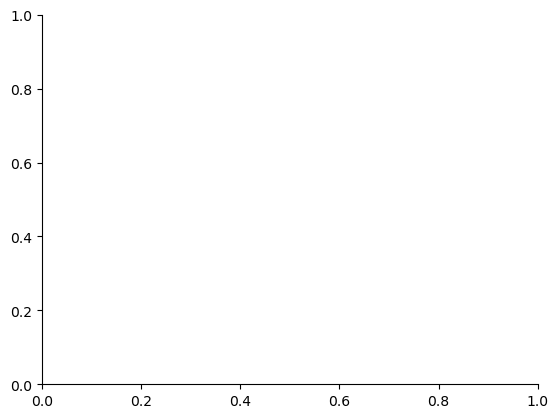

In [ ]:
plot(time_taylor, (distance, 0, distance_function_expr.subs(time, 250)))

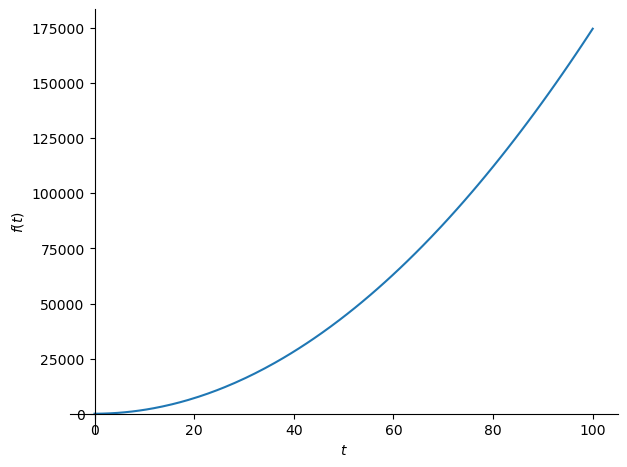

In [12]:
plot(distance_function_expr, (time, 0, 100))

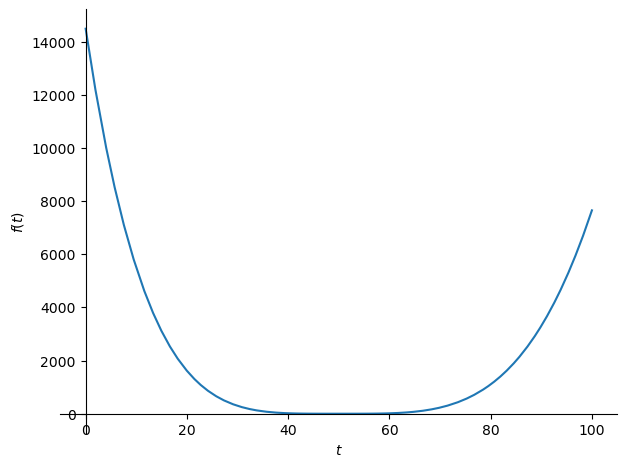

In [69]:
plot(distance_function_expr-series(distance_function_expr, time, 50, 4).removeO(), (time, 0, 100))

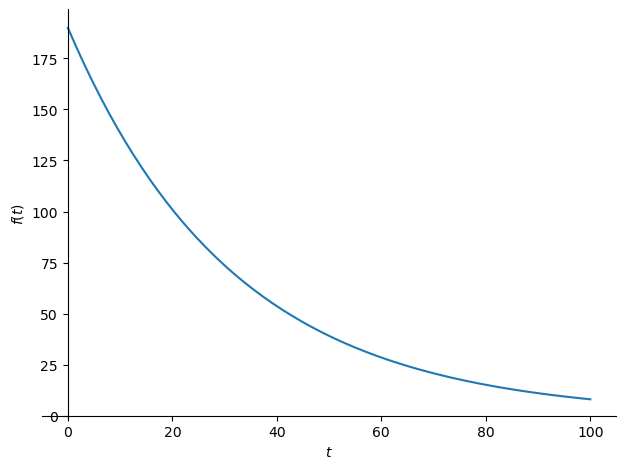

In [34]:
plot(distance_function_expr.diff(time, 2), (time, 0, 100))

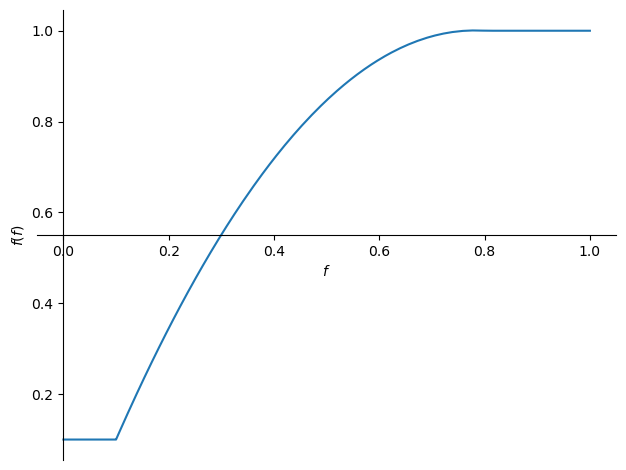

In [ ]:
plot(thrust_multiplier, (fuel_setting, 0, 1))

In [ ]:
R, x, y, a, b = ring("x, y, a, b", QQ)
p = x - 